In [138]:

%load_ext autoreload

%autoreload 2
import video_processing as vp
import numpy
from scipy import signal
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.distance import correlation#, euclidean, pdist, canberra
from roipoly import RoiPoly 
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
HEIGHT = 256
WIDTH = 256
TRUE_FRAMERATE = 28.815
IMAGING_FRAMERATE = 1/(34704.0/1e6)
SIGMA = 2

In [3]:
date = 20180420
timestamps_file = 'D:/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm_timestamps.raw'
video_file = 'D:/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm.h264'
subset_behaviour_file = 'D:/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm_subset_interpolated.raw'
l_mouse_processed_file = 'D:/2_mice/20180420/Experiment_2/LEFT_corrected_g_by_b_processed__interp_dff0_bandpass0.01-12.0Hz_MM803L_April-20_1304_experiment-2_M903R_wt_non-cage-mates_first_meet_together_12mm.raw'
r_mouse_processed_file = 'D:/2_mice/20180420/Experiment_2/RIGHT_corrected_g_by_b_processed__interp_dff0_bandpass0.01-12.0Hz_MM903R_April-20_1305_experiment-2_M803L_wt_non-cage-mates_first_meet_together_12mm.raw'
l_mouse_green_frame_file = 'D:/2_mice/20180420/Experiment_2/LEFT_RAW_GREEN_FRAME.npy'
r_mouse_green_frame_file = 'D:/2_mice/20180420/Experiment_2/RIGHT_RAW_GREEN_FRAME.npy'

### !!! TODO Load Calcium Imaging and Gaussian Filter

### Load raw green frames to create masks

In [185]:
l_green_frame = vp.downsample(
    numpy.load(l_mouse_green_frame_file), (64, 64)
)
r_green_frame = vp.downsample(
    numpy.load(r_mouse_green_frame_file), (64, 64)
)

In [186]:
# Separated mice loading
l_mouse_frames = vp.extract_RAW_frames(
    l_mouse_processed_file,
    WIDTH,
    HEIGHT,
    num_channels=1,
    dtype='float32'
)
l_mouse_frames[numpy.where(l_mouse_frames == -numpy.inf)] = -1
downsampled_l_mouse_frames = numpy.zeros((l_mouse_frames.shape[0], 64, 64))

r_mouse_frames = vp.extract_RAW_frames(
    r_mouse_processed_file,
    WIDTH,
    HEIGHT,
    num_channels=1,
    dtype='float32'
)
r_mouse_frames[numpy.where(r_mouse_frames==-numpy.inf)] = -1
downsampled_r_mouse_frames = numpy.zeros((r_mouse_frames.shape[0], 64, 64))

In [187]:
for i in range(l_mouse_frames.shape[0]):
    l_mouse_frames[i] = gaussian_filter(l_mouse_frames[i], SIGMA)                                      
    r_mouse_frames[i] = gaussian_filter(r_mouse_frames[i], SIGMA)
l_mouse_frames = vp.downsample(l_mouse_frames, (64, 64))
r_mouse_frames = vp.downsample(r_mouse_frames, (64, 64))

### Load behaviour video

In [69]:
behaviour_frames = vp.extract_RAW_frames(
    subset_behaviour_file, 
    320, 
    180, 
    num_channels=1
)

### !!! Todo Mask combined frames

### Mask the individual brains

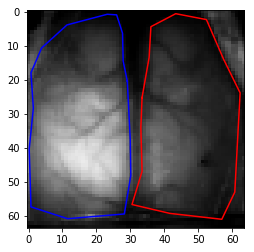

In [13]:
%matplotlib qt
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Left mouse left hemisphere')
l_mouse_left_hem = RoiPoly(color='b')

%matplotlib qt
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Left mouse right hemisphere')
l_mouse_right_hem = RoiPoly(color='r')

# Let's see what we have
%matplotlib inline
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
l_mouse_left_hem.display_roi()
l_mouse_right_hem.display_roi()

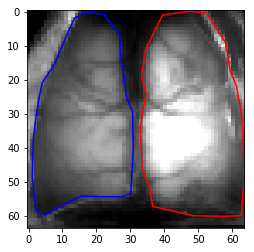

In [14]:
%matplotlib qt
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Right mouse left hemisphere')
r_mouse_left_hem = RoiPoly(color='b')

%matplotlib qt
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Right mouse right hemisphere')
r_mouse_right_hem = RoiPoly(color='r')

# Let's see what we have
%matplotlib inline
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
r_mouse_left_hem.display_roi()
r_mouse_right_hem.display_roi()

### Create and Plot the masks

In [70]:
l_mouse_mask = numpy.logical_or(
    l_mouse_left_hem.get_mask(l_green_frame), 
    l_mouse_right_hem.get_mask(l_green_frame)
)
r_mouse_mask = numpy.logical_or(
    r_mouse_left_hem.get_mask(r_green_frame), 
    r_mouse_right_hem.get_mask(r_green_frame)
)

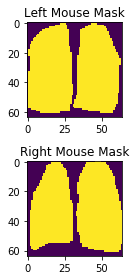

In [71]:
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(l_mouse_mask)
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.imshow(r_mouse_mask)
plt.tight_layout()

In [ ]:
### !!! save the masks
try:
    numpy.save(directory+experiment+"all_maps.npy", all_masks)
except:
    raise NameError("There was no all_masks file, double check.")
numpy.save(directory+experiment+"LM_mask.npy", left_mouse_mask)
numpy.save(directory+experiment+"RM_mask.npy", right_mouse_mask)

In [57]:
### !!! Load old mask?

### Calculate Global signal

In [188]:
l_global_signal, l_mean_g, l_beta_g = vp.global_signal(
    l_mouse_frames[:, l_mouse_mask]
)
r_global_signal, r_mean_g, r_beta_g = vp.global_signal(
    r_mouse_frames[:, r_mouse_mask]
)

l_mouse_frames[:, l_mouse_mask] = (
    l_mouse_frames[:, l_mouse_mask]
    - l_global_signal
)
r_mouse_frames[:, r_mouse_mask] = (
    r_mouse_frames[:, r_mouse_mask]
    - r_global_signal
)

In [ ]:
# mask out the untouched values
l_mouse_frames[:, ~l_mouse_mask] = -100
r_mouse_frames[:, ~r_mouse_mask] = -100

# save the frames
# !!!
left_mouse_frames.astype(numpy.float32).tofile(
    directory + experiment + "left_mouse_gsr_frames.raw"
)
right_mouse_frames.astype(numpy.float32).tofile(
    directory + experiment + "right_mouse_gsr_frames.raw"
)

### Replace Combined by the Global signal of the mice

In [ ]:
l_mouse_frames[:, l_mouse_mask] = l_global_signal
r_mouse_frames[:, r_mouse_mask] = r_global_signal

combined_frames = numpy.zeros(
    (l_mouse_frames.shape[0], 64, 128)
)
combined_frames[:, :, :64] = l_mouse_frames
combined_frames[:, :, 64:] = r_mouse_frames

# !!!
combined_frames.tofile(directory+experiment+"gsr_testing.raw")

### Plot the temporal global mean across space

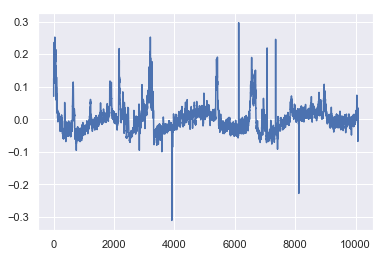

In [191]:
plt.plot(l_mean_g[:, 0]) # temporal mean across index [:,0,0]

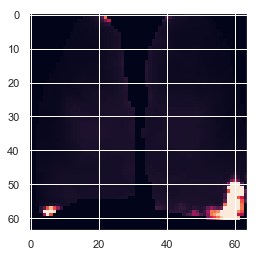

In [192]:
image = numpy.zeros((64, 64))
image[r_mouse_mask] = r_beta_g[0,:]
plt.imshow(image, vmin=0, vmax=1.7)

### Plot spectrogram of the means of the raw frames

Text(0.5, 0, 'Time [sec]')

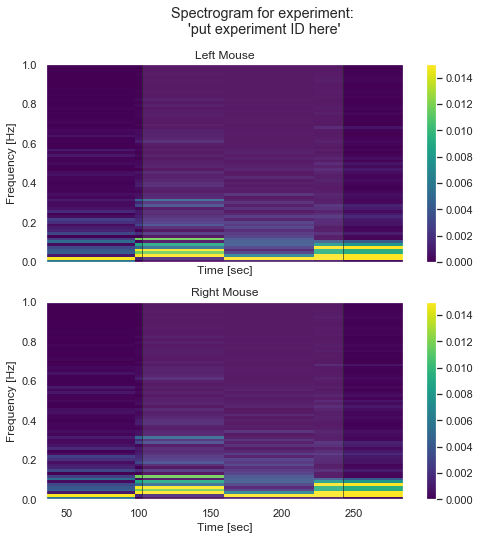

In [193]:
plt.figure(figsize=(8, 8))

# start and stop indices
start_interaction = 2938
end_interaction = 6980

start_interaction = numpy.round(float(start_interaction)/IMAGING_FRAMERATE, 3)
end_interaction = numpy.round(float(end_interaction)/IMAGING_FRAMERATE, 3)

plt.suptitle("Spectrogram for experiment:\n 'put experiment ID here'")
fs = IMAGING_FRAMERATE

f, t, Sxx = signal.spectrogram(l_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
ax1 = plt.subplot(211)
plt.title("Left Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')
plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.setp(ax1.get_xticklabels(), visible=False)


f, t, Sxx = signal.spectrogram(l_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
plt.subplot(212)
plt.title("Right Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')
plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# !!! plt.savefig(directory+experiment+title+"_spectrogram.png")

# Plot bandpass filtered global temporal signal and inverse? correlation

(0, 10084)

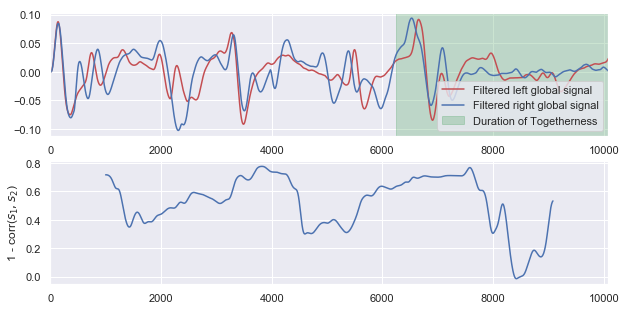

In [194]:
plt.figure(figsize = (10,5))

order = 3
fs = IMAGING_FRAMERATE
cutoff_low = 0.01
cutoff_high = 0.1


def butter_bandpass(cutoff_low, cutoff_high, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq
    Wn = [normal_cutoff_low, normal_cutoff_high]
    b, a = signal.butter(
        order, Wn, btype="bandpass", analog=False
    )
    return b, a


def butter_bandpass_filter(
    data, cutoff_low, cutoff_high, fs, order=5
):
    b, a = butter_bandpass(
        cutoff_low, cutoff_high, fs, order=order
    )
    y = signal.lfilter(b, a, data)
    return y


s1 = butter_bandpass_filter(
    numpy.mean(l_global_signal[:, :], axis=1),
    cutoff_low,
    cutoff_high,
    fs,
    order,
)
s2 = butter_bandpass_filter(
    numpy.mean(r_global_signal[:, :], axis=1),
    cutoff_low,
    cutoff_high,
    fs,
    order,
)

window_size = 2000
corrs = []
for i in range(len(s1) - window_size):
    corrs.append(
        1
        - correlation(
            s1[i : i + window_size], s2[i : i + window_size]
        )
    )
start_interaction = 6240
end_interaction = 12853
plt.subplot(211)
plt.plot(s1, "r", label="Filtered left global signal")
plt.plot(s2, label="Filtered right global signal")
plt.axvspan(
    start_interaction,
    end_interaction,
    color="g",
    alpha=0.3,
    label="Duration of Togetherness",
)
plt.xlim(0, len(s1))
plt.legend()

plt.subplot(212)
lol = 200
corr_x_axis = numpy.linspace(
    window_size / 2, len(s1) - window_size / 2, len(corrs)
)
#corrs = running_mean(corrs, lol)
plt.plot(corr_x_axis, corrs)
plt.ylabel('1 - corr($s_1,s_2$)')
plt.xlim([0, len(s1)])

### Plot the global signals to show synchronisation

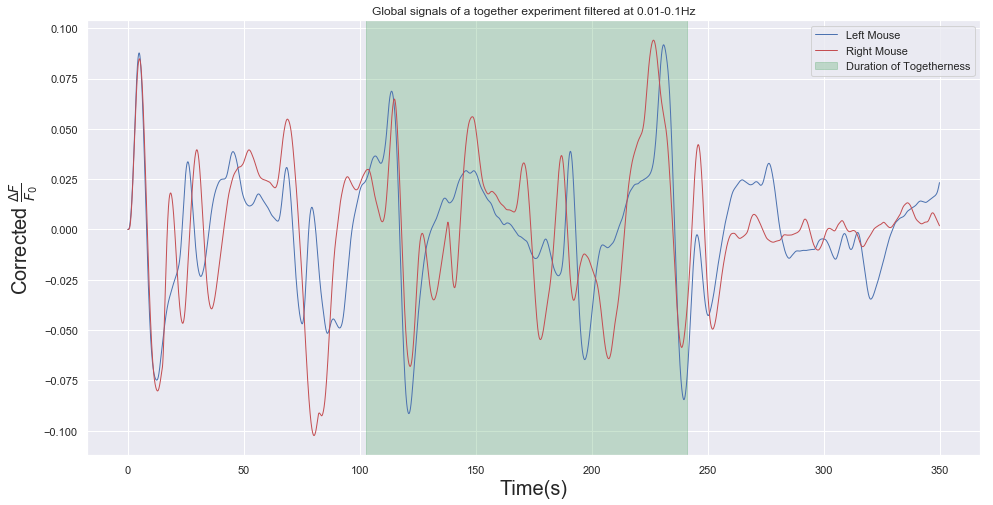

In [195]:
sns.set()
exp_duration = len(s1) / IMAGING_FRAMERATE
time_axis = numpy.linspace(0, exp_duration, len(s1))
start_interaction = 2962 / IMAGING_FRAMERATE
end_interaction = 6950 / IMAGING_FRAMERATE
plt.figure(figsize=(16, 8))
plt.title(
    "Global signals of a together experiment filtered at %s-%sHz"
    % (str(cutoff_low), str(cutoff_high))
)
plt.plot(
    time_axis,
    s1,
    linewidth=1.0,
    color="b",
    label="Left Mouse",
)
plt.plot(
    time_axis,
    s2,
    linewidth=1.0,
    color="r",
    label="Right Mouse",
)
plt.axvspan(
    start_interaction,
    end_interaction,
    color="g",
    alpha=0.3,
    label="Duration of Togetherness",
)
plt.ylabel(r"Corrected $\frac{\Delta F}{F_0}$", size=20)
plt.xlabel("Time(s)", size=20)
plt.legend()

# Plot correlations between bandpass filtered mean signals signals at different frequency bands

In [206]:
frequency_bands = (
    0.01,
    0.1,
    0.5,
    1.0,
    2.0,
    3.0,
    4.0,
    6.0,
    8.0,
    10.0,
    12.0,
)

window_size = 3800
fs = IMAGING_FRAMERATE
order = 3
total_bins = l_global_signal.shape[0] - window_size
correlation_image = numpy.zeros(          # Make empty array we will now populate
    (len(frequency_bands) - 1, total_bins)
)
og_s1 = numpy.copy(l_mean_g[:, 0])  # select full temporal means
og_s2 = numpy.copy(r_mean_g[:, 0]) 

frequency_labels = []
for i, (low, high) in enumerate(zip(frequency_bands, frequency_bands[1:])):
    frequency_labels.append(
        str(low) + "-" + str(high) + "Hz"
    )
    s1 = butter_bandpass_filter(
        og_s1, low, high, fs, order
    )
    s2 = butter_bandpass_filter(
        og_s2, low, high, fs, order
    )
    # correlation inside moving window at current frequency band
    for j in range(len(s1) - window_size):
        correlation_image[i, j] = 1 - correlation(
            s1[j : j + window_size], s2[j : j + window_size]
        )
#np.save(
#    directory
#+ experiment
#+ "GFP_frequency_split_correlation_filtered_ws=%s.py"
#    % str(window_size),
#    cool_image,
#)


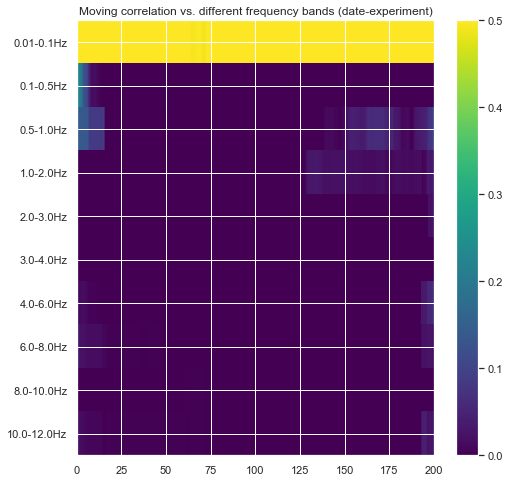

In [207]:
plt.figure(figsize=(8, 8))
# !!!
plt.title(
    "Moving correlation vs. different frequency bands (%s-%s)"%('date', 'experiment')
)
y_ticks = numpy.arange(cool_image.shape[0])+0.5
y_ticks = numpy.flipud(y_ticks)
plt.imshow(
    correlation_image, 
    cmap='viridis', 
    extent=[0,200,0,10],
    aspect='auto', 
    vmin=0.0, 
    vmax=0.5
)
plt.yticks(y_ticks, frequency_labels)
plt.colorbar()
# !!! 
#plt.savefig(directory+experiment+"frequency_split_figure.svg")

### Shift and plot signal correlations - shift s2 relative to s1 and see where they correlate the most

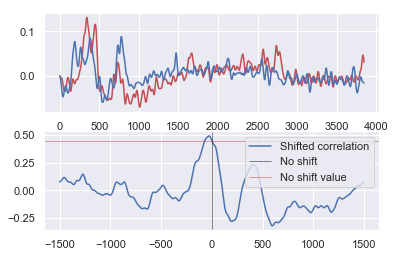

In [211]:
plt.figure()
order=3
fs=IMAGING_FRAMERATE
cutoff=0.5

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# indices of start and end frames 
interaction_start = 6240
interaction_end = 12853
corrs = []
shift_x = []

og_s1 = butter_lowpass_filter(
    numpy.mean(l_global_signal[interaction_start:interaction_end, :], axis=1), 
    cutoff, 
    fs, 
    order
)
og_s2 = butter_lowpass_filter(
    numpy.mean(r_global_signal[interaction_start:interaction_end, :], axis=1),
    cutoff,
    fs,
    order
)
for i in range(-1500, 1500):
    s1 = numpy.copy(og_s1)
    s2 = numpy.copy(og_s2)

    '''
    Shift one signal over the other
    '''
    if i != 0:
        number_of_frames_to_shift = i
        tmp = numpy.copy(s2[:number_of_frames_to_shift])
        s2[:-number_of_frames_to_shift] = numpy.copy(s2[number_of_frames_to_shift:])
        s2[-number_of_frames_to_shift:] = tmp

    corrs.append(1-correlation(s1, s2))
    shift_x.append(i)
    
shift_x = numpy.asarray(shift_x)
corrs = numpy.asarray(corrs)
    
plt.subplot(211)
plt.plot(og_s1, 'r')
plt.plot(og_s2)
plt.subplot(212)
plt.plot(shift_x, corrs, color='b', label="Shifted correlation")
plt.axvline(0, color='k', linewidth=0.5, label="No shift")
plt.axhline(corrs[numpy.where(shift_x==0)][0], color='r', linewidth=0.5, label="No shift value")
plt.legend()


In [225]:
corrs

[(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
         52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
         69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
         86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
  array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 99, 98,
         97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81,
         80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64,
         63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47,
         46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30,
         29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16])),
 (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 2